In [2]:
import pandas as pd
import numpy as np
import hashlib
import uuid

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score

## 1. CARGA DE DATOS

In [4]:
df = pd.read_csv("datos_moodle.csv")

print("Datos cargados correctamente")
print(df.head())

Datos cargados correctamente
   codigo_estudiante  edad sexo periodo_academico  nota_primer_parcial  \
0           20248998    21    M           2025-II                    7   
1           20248134    19    M           2025-II                    5   
2           20254712    20    F           2025-II                   12   
3           20257253    17    M           2025-II                   14   
4           20256938    20    M           2025-II                   19   

   nota_segundo_parcial  nota_tercer_parcial  promedio_previo  \
0                    17                   20              7.5   
1                    18                   15             10.9   
2                    13                   16              7.7   
3                    11                   15             14.2   
4                    19                   16             15.2   

   total_accesos_lms  tiempo_total_conexion_min  tareas_entregadas  \
0                 81                        623                  

=== VARIABLES CATEGÓRICAS DEL DATASET ===

Variable: sexo
  Tipo     : object
  Valores  : ['M', 'F']

  Distribución de frecuencias:
    M: 274 estudiantes (58.2%)
    F: 197 estudiantes (41.8%)

Variable: periodo_academico
  Tipo     : object
  Valores únicos: ['2025-II']
  Variabilidad   : Sin variabilidad (valor constante)
  → Excluida del modelo por no aportar capacidad discriminativa.



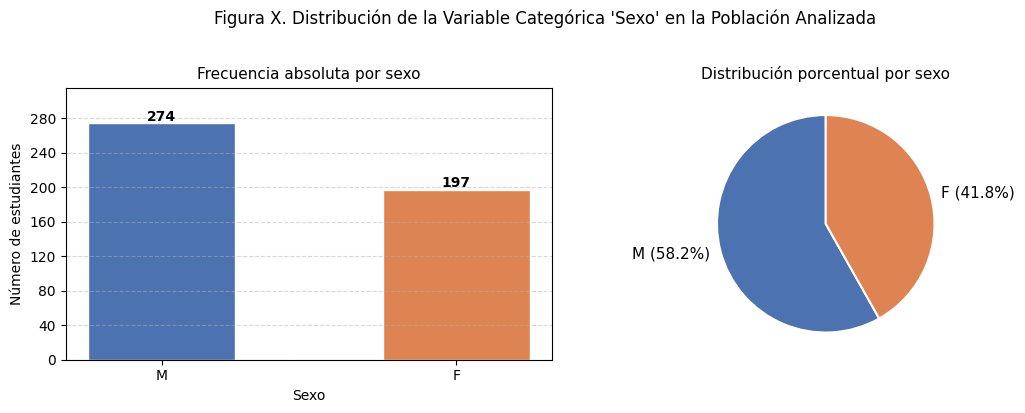

Gráfico de distribución de sexo guardado en: shap_results/distribucion_sexo.png

=== RESUMEN: TRATAMIENTO DE VARIABLES CATEGÓRICAS ===
  'sexo'              → Excluida por criterio ético (minimización de datos, Ley N.º 29733)
  'periodo_academico' → Excluida por valor constante (sin aporte predictivo)
  Variables incluidas en el modelo: 11 variables numéricas


In [11]:
# ============================================================
# ANÁLISIS DE VARIABLES CATEGÓRICAS
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

print("=== VARIABLES CATEGÓRICAS DEL DATASET ===\n")

# --- Variable 1: sexo ---
print("Variable: sexo")
print(f"  Tipo     : {df['sexo'].dtype}")
print(f"  Valores  : {df['sexo'].unique().tolist()}")
freq_sexo = df["sexo"].value_counts()
pct_sexo  = df["sexo"].value_counts(normalize=True) * 100
print("\n  Distribución de frecuencias:")
for val in freq_sexo.index:
    print(f"    {val}: {freq_sexo[val]} estudiantes ({pct_sexo[val]:.1f}%)")

# --- Variable 2: periodo_academico ---
print("\nVariable: periodo_academico")
print(f"  Tipo     : {df['periodo_academico'].dtype}")
print(f"  Valores únicos: {df['periodo_academico'].unique().tolist()}")
print(f"  Variabilidad   : {'Sin variabilidad (valor constante)' if df['periodo_academico'].nunique() == 1 else 'Con variabilidad'}")
print("  → Excluida del modelo por no aportar capacidad discriminativa.\n")

# --- Gráfico de distribución: sexo ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Gráfico 1: Barras de frecuencia
colores = ["#4C72B0", "#DD8452"]
axes[0].bar(
    freq_sexo.index,
    freq_sexo.values,
    color=colores,
    edgecolor="white",
    width=0.5
)
axes[0].set_title("Frecuencia absoluta por sexo", fontsize=11)
axes[0].set_xlabel("Sexo")
axes[0].set_ylabel("Número de estudiantes")
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for i, (val, cnt) in enumerate(zip(freq_sexo.index, freq_sexo.values)):
    axes[0].text(i, cnt + 3, str(cnt), ha="center", fontsize=10, fontweight="bold")
axes[0].set_ylim(0, freq_sexo.max() * 1.15)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Gráfico 2: Pastel de porcentajes
axes[1].pie(
    pct_sexo.values,
    labels=[f"{v} ({p:.1f}%)" for v, p in zip(pct_sexo.index, pct_sexo.values)],
    colors=colores,
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
    textprops={"fontsize": 11}
)
axes[1].set_title("Distribución porcentual por sexo", fontsize=11)

plt.suptitle(
    "Figura X. Distribución de la Variable Categórica 'Sexo' en la Población Analizada",
    fontsize=12,
    y=1.02
)
plt.tight_layout()
plt.savefig("shap_results/distribucion_sexo.png", dpi=150, bbox_inches="tight")
plt.show()

print("Gráfico de distribución de sexo guardado en: shap_results/distribucion_sexo.png")

# --- Resumen ejecutivo ---
print("\n=== RESUMEN: TRATAMIENTO DE VARIABLES CATEGÓRICAS ===")
print(f"  'sexo'              → Excluida por criterio ético (minimización de datos, Ley N.º 29733)")
print(f"  'periodo_academico' → Excluida por valor constante (sin aporte predictivo)")
print(f"  Variables incluidas en el modelo: {len(features)} variables numéricas")

## 2. ANONIMIZACION (Ley 29733)

In [5]:
def anonymize_id(value, salt):
    return hashlib.sha256(f"{value}{salt}".encode()).hexdigest()

salt = uuid.uuid4().hex
df["id_anonimo"] = df["codigo_estudiante"].apply(lambda x: anonymize_id(x, salt))
df.drop(columns=["codigo_estudiante"], inplace=True)

print("Anonimización aplicada")

Anonimización aplicada


## 3. VARIABLE OBJETIVO (RIESGO ACADEMICO)

In [6]:
df["riesgo_academico"] = (df["nota_final"] < 11).astype(int)

## 4. INGENIERIA DE CARACTERISTICAS

In [7]:
df["ratio_tareas"] = df["tareas_entregadas"] / df["tareas_totales"]
df["ratio_asistencia"] = df["asistencias"] / df["clases_totales"]

df["engagement_score"] = (
    df["total_accesos_lms"] * 0.4 +
    df["participaciones_foro"] * 0.3 +
    df["tiempo_total_conexion_min"] * 0.3
)

## 5. SELECCION DE VARIABLES

In [8]:
features = [
    "edad",
    "nota_primer_parcial",
    "nota_segundo_parcial",
    "promedio_previo",
    "total_accesos_lms",
    "tiempo_total_conexion_min",
    "participaciones_foro",
    "ratio_tareas",
    "ratio_asistencia",
    "engagement_score",
    "retroalimentaciones_docente"
]

X = df[features]
y = df["riesgo_academico"]

## 6. PREPROCESAMIENTO

In [9]:
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

=== Pares de variables con correlación > 0.60 ===
  tiempo_total_conexion_min ↔ engagement_score: r = 0.990
  ⚠️ Colinealidad severa: tiempo_total_conexion_min ↔ engagement_score


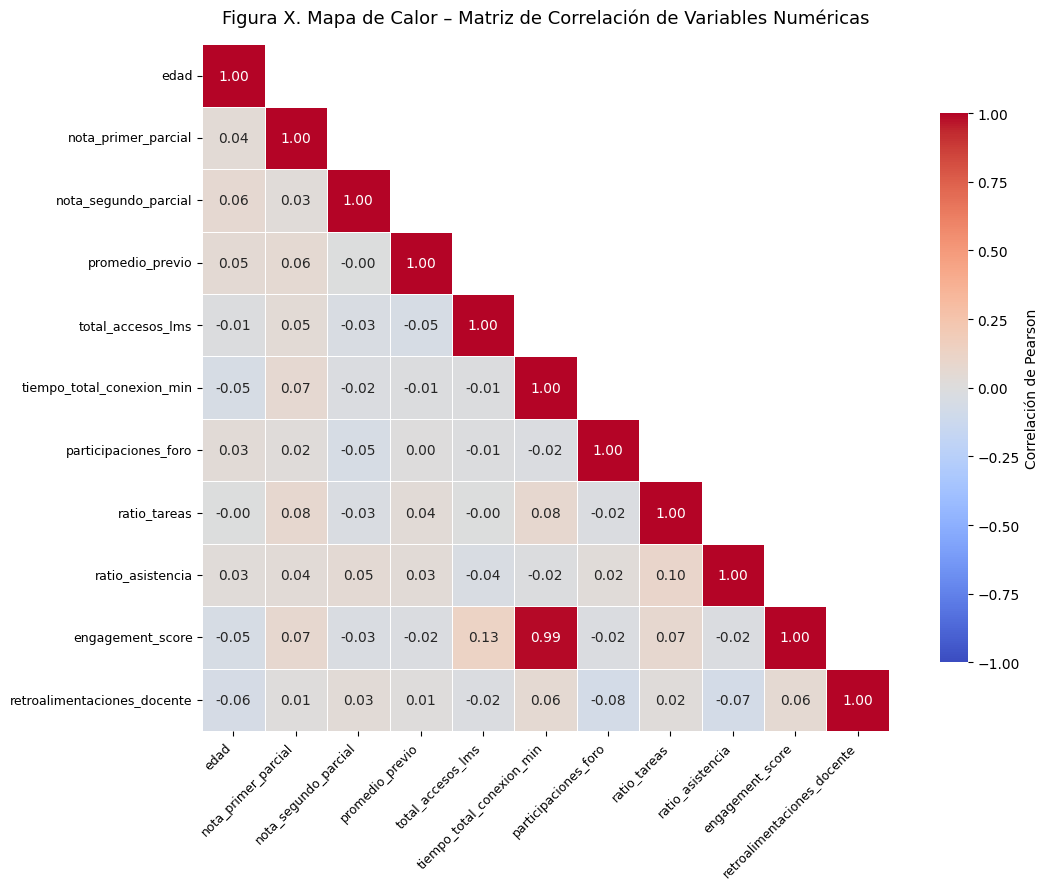


Matriz de correlación guardada en: shap_results/matriz_correlacion.png


In [10]:
# ============================================================
# ANÁLISIS DE CORRELACIÓN Y COLINEALIDAD
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reconstruir DataFrame con features antes del escalado
# (usar los datos antes de imputer/scaler para interpretabilidad)
df_corr = pd.DataFrame(
    imputer.transform(df[features]),
    columns=features
)

# Matriz de correlación de Pearson
corr_matrix = df_corr.corr(method="pearson")

# Identificar pares con correlación alta (> 0.6)
print("=== Pares de variables con correlación > 0.60 ===")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.60:
            print(f"  {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: r = {val:.3f}")

# Identificar si hay colinealidad severa (> 0.80)
colineal_severa = False
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.80:
            colineal_severa = True
            print(f"  ⚠️ Colinealidad severa: {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}")

if not colineal_severa:
    print("  ✅ No se detectó colinealidad severa (ningún par supera r = 0.80)")

# Mapa de calor
plt.figure(figsize=(12, 9))
mask = pd.DataFrame(False, index=corr_matrix.index, columns=corr_matrix.columns)
# Ocultar triángulo superior para mayor legibilidad
import numpy as np
mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor="white",
    mask=mask_upper,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlación de Pearson"}
)

plt.title(
    "Figura X. Mapa de Calor – Matriz de Correlación de Variables Numéricas",
    fontsize=13,
    pad=15
)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig("shap_results/matriz_correlacion.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nMatriz de correlación guardada en: shap_results/matriz_correlacion.png")

## 7. DIVISION TRAIN / TEST

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

## 8. ENTRENAMIENTO DE MODELOS

In [13]:
models = {
    "Regresion_Logistica": LogisticRegression(max_iter=1000),
    "Random_Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Red_Neuronal": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)

    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred))

    results.append({
        "Modelo": name,
        "ROC_AUC": auc
    })


Modelo: Regresion_Logistica
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.64      0.69      0.67        13

    accuracy                           0.92       118
   macro avg       0.80      0.82      0.81       118
weighted avg       0.93      0.92      0.92       118


Modelo: Random_Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       105
           1       1.00      0.62      0.76        13

    accuracy                           0.96       118
   macro avg       0.98      0.81      0.87       118
weighted avg       0.96      0.96      0.95       118


Modelo: Red_Neuronal
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       105
           1       0.53      0.62      0.57        13

    accuracy                           0.90       118
   macro avg       0.74      0.77      0.76       118


## 9. RESULTADOS COMPARATIVOS

In [14]:
results_df = pd.DataFrame(results)
results_df.to_csv("resultados_modelos.csv", index=False)

print("\nResultados comparativos guardados")


Resultados comparativos guardados


## 10. DATASET FINAL PARA POWER BI

In [15]:
df_powerbi = df.copy()
df_powerbi["probabilidad_riesgo"] = models["Random_Forest"].predict_proba(X)[:, 1]

df_powerbi.to_csv("dataset_powerbi.csv", index=False)

print("Dataset para Power BI generado correctamente")

Dataset para Power BI generado correctamente


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

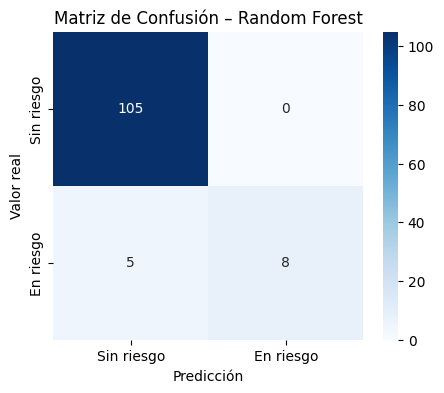

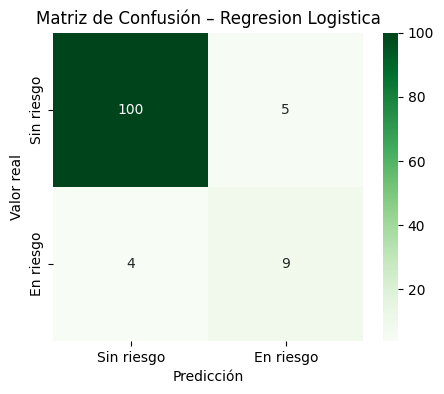

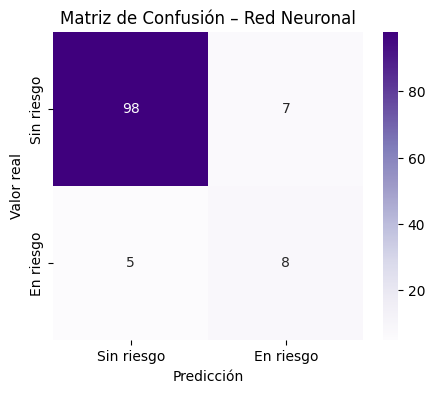

In [17]:
model_names = {
    "Random_Forest": "Blues",
    "Regresion_Logistica": "Greens",
    "Red_Neuronal": "Purples"
}

for model_name, cmap in model_names.items():
    y_pred = models[model_name].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        xticklabels=["Sin riesgo", "En riesgo"],
        yticklabels=["Sin riesgo", "En riesgo"]
    )
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.title(f"Matriz de Confusión – {model_name.replace('_', ' ')}")
    plt.show()

In [18]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_info = {
    "Random Forest": ("Random_Forest", "Blues"),
    "Regresión Logística": ("Regresion_Logistica", "Greens"),
    "Red Neuronal": ("Red_Neuronal", "Purples")
}

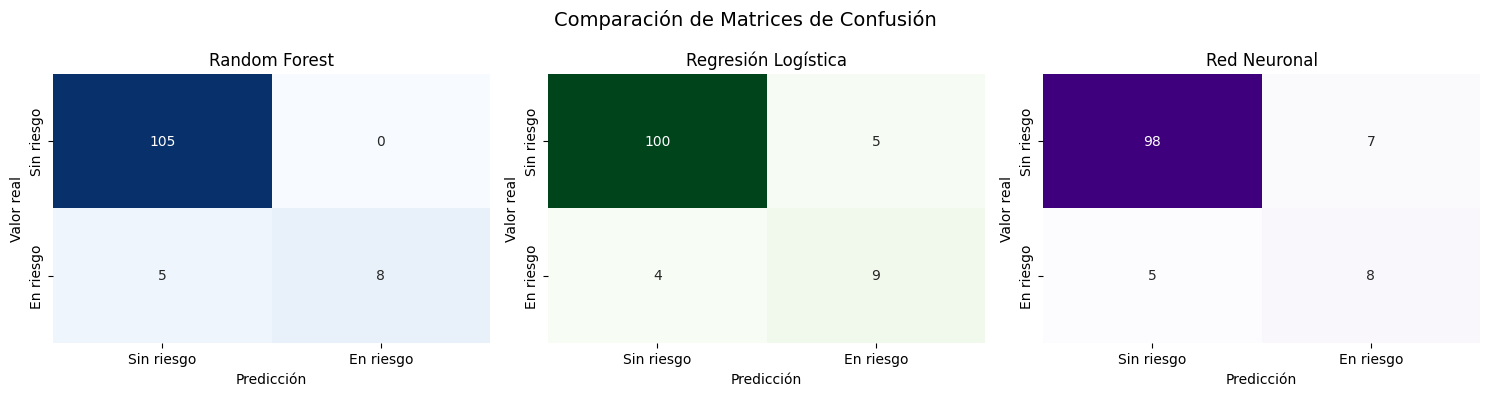

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = []

for ax, (name, (key, cmap)) in zip(axes, model_info.items()):
    y_pred = models[key].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=False,
        xticklabels=["Sin riesgo", "En riesgo"],
        yticklabels=["Sin riesgo", "En riesgo"],
        ax=ax
    )

    ax.set_title(name)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Valor real")

    # Métricas
    metrics.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

plt.suptitle("Comparación de Matrices de Confusión", fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
df_metrics = pd.DataFrame(metrics)
df_metrics.set_index("Modelo", inplace=True)

df_metrics.round(3)

,Accuracy,Precision,Recall,F1
Modelo,,,,
Random Forest,0.958,1.000,0.615,0.762
Regresión Logística,0.924,0.643,0.692,0.667
Red Neuronal,0.898,0.533,0.615,0.571


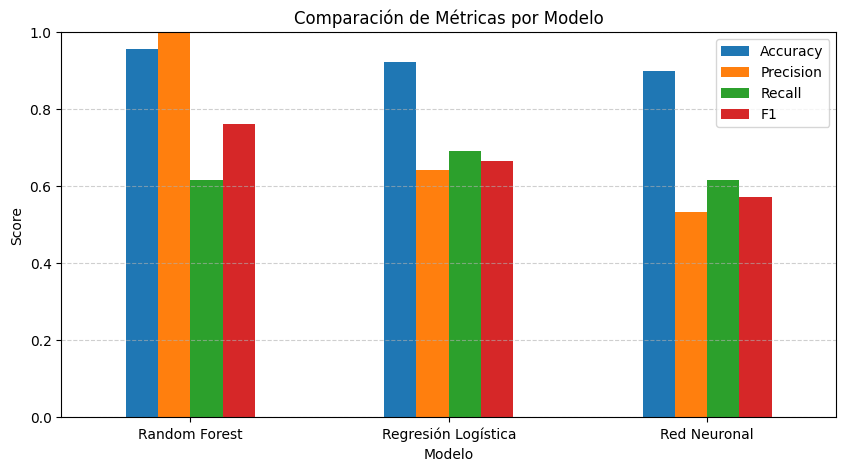

In [21]:
df_metrics.plot(
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de Métricas por Modelo")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

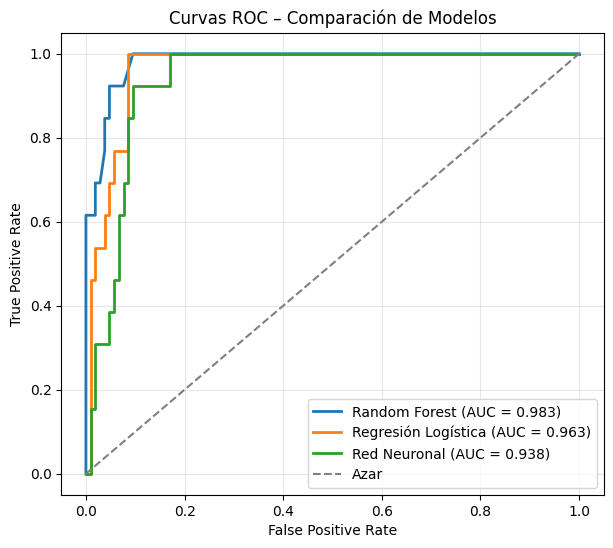

In [23]:
plt.figure(figsize=(7,6))

for name, (key, _) in model_info.items():
    
    model = models[key]
    
    # Probabilidades de la clase positiva (En riesgo)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f"{name} (AUC = {roc_auc:.3f})"
    )

# Línea base (clasificador aleatorio)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Azar")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – Comparación de Modelos")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

for m in metrics:
    key = model_info[m["Modelo"]][0]
    y_proba = models[key].predict_proba(X_test)[:, 1]
    m["AUC"] = roc_auc_score(y_test, y_proba)

df_metrics = pd.DataFrame(metrics).set_index("Modelo")
df_metrics.round(3)

,Accuracy,Precision,Recall,F1,AUC
Modelo,,,,,
Random Forest,0.958,1.000,0.615,0.762,0.983
Regresión Logística,0.924,0.643,0.692,0.667,0.963
Red Neuronal,0.898,0.533,0.615,0.571,0.938


Tipo de shap_values_raw : <class 'numpy.ndarray'>
Formato: ndarray de shape (118, 11, 2)
Shape final de shap_vals: (118, 11)
Shape de X_test_df     : (118, 11)


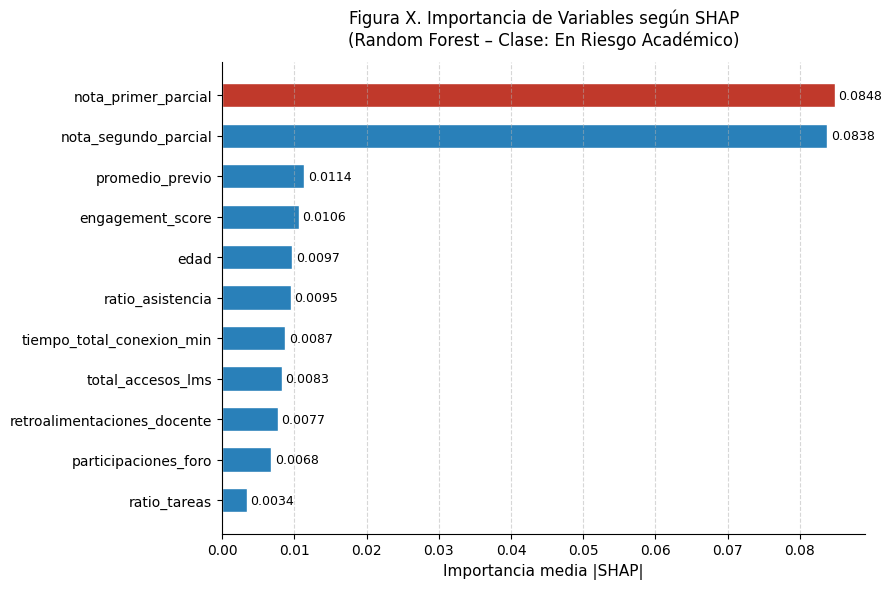

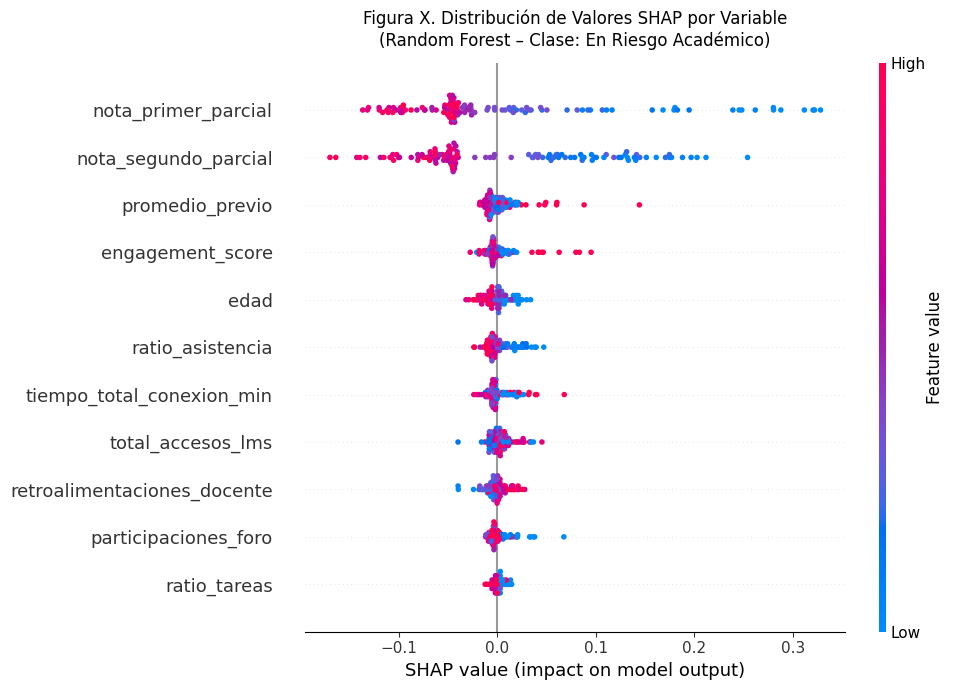


=== RANKING DE IMPORTANCIA DE VARIABLES (SHAP) ===
Pos    Variable                               |SHAP| medio
----------------------------------------------------------
  1    nota_primer_parcial                       0.0848  ◄ Mayor impacto
  2    nota_segundo_parcial                      0.0838
  3    promedio_previo                           0.0114
  4    engagement_score                          0.0106
  5    edad                                      0.0097
  6    ratio_asistencia                          0.0095
  7    tiempo_total_conexion_min                 0.0087
  8    total_accesos_lms                         0.0083
  9    retroalimentaciones_docente               0.0077
  10   participaciones_foro                      0.0068
  11   ratio_tareas                              0.0034

=== TOP 3 PARA EL TEXTO DE LA TESIS ===
  1. 'nota_primer_parcial': importancia SHAP = 0.0848
  2. 'nota_segundo_parcial': importancia SHAP = 0.0838
  3. 'promedio_previo': importancia SHAP = 0.01

In [26]:
# ============================================================
# CORRECCIÓN 13: ANÁLISIS SHAP COMPLETO — FIXED
# ============================================================
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.makedirs("shap_results", exist_ok=True)

# Asegurar que X_test sea DataFrame con nombres de columnas
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=features)
else:
    X_test_df = X_test.copy()

rf_model = models["Random_Forest"]

# --- Explainer SHAP con output_names explícito ---
explainer = shap.TreeExplainer(
    rf_model,
    feature_perturbation="tree_path_dependent"
)
shap_values_raw = explainer.shap_values(X_test_df)

# --- Manejo robusto de todas las versiones de SHAP ---
print(f"Tipo de shap_values_raw : {type(shap_values_raw)}")

if isinstance(shap_values_raw, list):
    # Versión antigua: lista de 2 arrays (clase 0 y clase 1)
    print(f"Formato: lista de {len(shap_values_raw)} arrays")
    print(f"Shape por clase: {shap_values_raw[0].shape}")
    shap_vals = shap_values_raw[1]          # Clase 1 = En riesgo

elif isinstance(shap_values_raw, np.ndarray):
    print(f"Formato: ndarray de shape {shap_values_raw.shape}")
    
    if shap_values_raw.ndim == 3:
        # Versión nueva: shape (n_samples, n_features, n_classes)
        shap_vals = shap_values_raw[:, :, 1]    # Clase 1 = En riesgo
    elif shap_values_raw.ndim == 2:
        # Ya tiene shape (n_samples, n_features)
        shap_vals = shap_values_raw
    else:
        raise ValueError(f"Shape inesperado: {shap_values_raw.shape}")
else:
    # Objeto Explanation de SHAP moderno
    print(f"Formato: objeto Explanation")
    if hasattr(shap_values_raw, 'values'):
        vals = shap_values_raw.values
        if vals.ndim == 3:
            shap_vals = vals[:, :, 1]
        else:
            shap_vals = vals
    else:
        raise ValueError("Formato de SHAP no reconocido")

print(f"Shape final de shap_vals: {shap_vals.shape}")
print(f"Shape de X_test_df     : {X_test_df.shape}")
assert shap_vals.shape == X_test_df.shape, \
    f"Dimensiones incompatibles: {shap_vals.shape} vs {X_test_df.shape}"

# ===========================================
# GRÁFICO 1: Importancia media (Bar Plot)
# ===========================================
mean_shap = pd.Series(
    np.abs(shap_vals).mean(axis=0),
    index=features
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
colors = ["#c0392b" if v == mean_shap.max() else "#2980b9"
          for v in mean_shap.values]
bars = ax.barh(
    mean_shap.index,
    mean_shap.values,
    color=colors,
    edgecolor="white",
    height=0.6
)

for bar, val in zip(bars, mean_shap.values):
    ax.text(
        val + 0.0005,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.4f}",
        va="center", ha="left", fontsize=9
    )

ax.set_xlabel("Importancia media |SHAP|", fontsize=11)
ax.set_title(
    "Figura X. Importancia de Variables según SHAP\n"
    "(Random Forest – Clase: En Riesgo Académico)",
    fontsize=12, pad=12
)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("shap_results/shap_importancia_barras.png", dpi=150, bbox_inches="tight")
plt.show()

# ===========================================
# GRÁFICO 2: Beeswarm — usando Explanation object
# ===========================================
# Crear objeto Explanation correctamente para evitar el error dimensional
shap_explanation = shap.Explanation(
    values=shap_vals,                        # (n_samples, n_features) 2D
    base_values=np.full(
        shap_vals.shape[0],
        explainer.expected_value[1]          # Base value clase 1
        if isinstance(explainer.expected_value, (list, np.ndarray))
        else explainer.expected_value
    ),
    data=X_test_df.values,
    feature_names=features
)

plt.figure(figsize=(10, 7))
shap.plots.beeswarm(
    shap_explanation,
    max_display=len(features),
    show=False
)
plt.title(
    "Figura X. Distribución de Valores SHAP por Variable\n"
    "(Random Forest – Clase: En Riesgo Académico)",
    fontsize=12, pad=12
)
plt.gcf().set_size_inches(10, 7)
plt.tight_layout()
plt.savefig("shap_results/shap_beeswarm_completo.png", dpi=150, bbox_inches="tight")
plt.show()

# ===========================================
# RANKING EN CONSOLA
# ===========================================
ranking = mean_shap.sort_values(ascending=False)

print("\n=== RANKING DE IMPORTANCIA DE VARIABLES (SHAP) ===")
print(f"{'Pos':<6} {'Variable':<35} {'|SHAP| medio':>15}")
print("-" * 58)
for pos, (var, val) in enumerate(ranking.items(), start=1):
    marker = "  ◄ Mayor impacto" if pos == 1 else ""
    print(f"  {pos:<4} {var:<35} {val:>12.4f}{marker}")

print("\n=== TOP 3 PARA EL TEXTO DE LA TESIS ===")
for i, (var, val) in enumerate(ranking.head(3).items(), 1):
    print(f"  {i}. '{var}': importancia SHAP = {val:.4f}")

# ===========================================
# GUARDAR CSV
# ===========================================
pd.DataFrame({
    "Posicion": range(1, len(ranking) + 1),
    "Variable": ranking.index,
    "Importancia_SHAP_media": ranking.values
}).to_csv("shap_results/tabla_importancia_shap.csv", index=False)

print("\nArchivos guardados en shap_results/:")
print("  - shap_importancia_barras.png")
print("  - shap_beeswarm_completo.png")
print("  - tabla_importancia_shap.csv")